In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json

# Google Trends API para Python

Se pretende utilizar una API que nos permita hacer consultas a Google Trends con las siguientes características:
* Hacer consultas históricas con palabras clave
* Hacer consultas en tiempo real
* API preferentemente libre

La selección es a criterio del equipo, siempre que satisfaga los puntos anteriores.

# Pytrends

En el siguiente [enlace](https://pypi.org/project/pytrends/) se puede encontrar la documentación oficial de la API.

Para la instalación del módulo utilizar el siguiente comando:
>```python
>pip install pytrends
>```

## Conexión a Google
Ejecutar para obtener PATH de la API:
```python
import pytrends
pytrends.__file__
```

Primero se inicia un **objeto de conexión**.
```python
pytrends = TrendReq(hl='es-MX',
                    tz=300,
                    geo='MX',
                    timeout=(2,5),
                    proxies='',
                    retries=2,
                    backoff_factor=0,
                    requests_args=None)
```

Después se define la **carga de consulta** o [payload](https://openwebinars.net/blog/que-es-payload/)
```python
kw_list = ['certificado']
pytrends.build_payload(kw_list,
                       cat=0,
                       timeframe='today 5-y',
                       geo='MX',
                       gprop='')
```

In [2]:
from pytrends.request import TrendReq

## Métodos de la API
Los métodos de `pytrends` típicamente utilizan los siguientes parámetros:
* `kw_list`: Lista de pálabras clave o criterios de búsqueda
* `cat`: Categoría para reducir resultados
* `geo`: Abrebiación de dos letras de un país.
* `tz`: Offset de zona horaria en minutos, para más información ir a la [liga](https://en.wikipedia.org/wiki/UTC_offset)
* `timeframe`: Ventana de tiempo de consulta
* `gprop`: (Metadato) Propiedad de google que se quiere filtrar

Y permite consultar información a través de los siguientes métodos:

### Interés en el tiempo
Regresa datos históricos indexados para los momentos en los que los criterios de búsqueda, definidos en `kw_list`, tuvieron una mayor cantidad de búsquedas.

`Extraido de Google Trends`:
>Los números representan el interés de búsqueda en relación con el valor máximo de la lista correspondiente a la región y el período especificados. El valor 100 indica la popularidad máxima del término, 50 implica la mitad de popularidad, y 0 significa que no hubo suficientes datos para este término

In [3]:
def pytrends(kw_list, cat=0, timeframe='today 5-y'):
    query = TrendReq(hl='es-MX', tz=300, geo='MX')
    query.build_payload(kw_list=kw_list, cat=cat, timeframe=timeframe, geo='MX')
    
    return query

In [4]:
query = pytrends(['certificado'])

over_time = query.interest_over_time()
over_time.tail()

,certificado,isPartial
date,,
2022-10-02,14,False
2022-10-09,11,False
2022-10-16,13,False
2022-10-23,11,False
2022-10-30,10,True


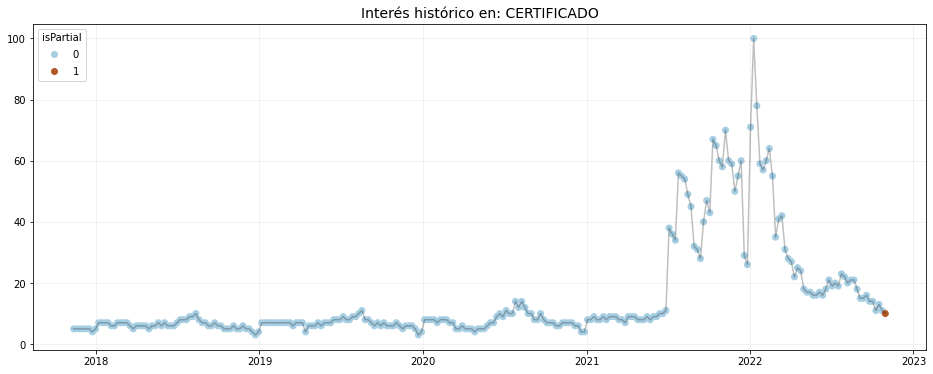

In [5]:
fig, ax = plt.subplots(figsize=(16,6))

scatter = ax.scatter(x=over_time.index, y=over_time['certificado'], c=over_time['isPartial'], cmap='Paired')
ax.plot(over_time.index, over_time['certificado'], color='black', alpha=0.25)

#Anotaciones y estilo
ax.set_title(label='Interés histórico en: CERTIFICADO', fontsize=14)
ax.legend(*scatter.legend_elements(), loc="upper left", title="isPartial")
ax.grid(alpha=0.2)

plt.show()

### Interés en el tiempo por hora
Regresa datos históricos por hora, indexados para los momentos en los que los criterios de búsqueda, definidos en `kw_list`, tuvieron una mayor cantidad de búsquedas.

El significado del valor de la consulta es el mismo que en `interés en el tiempo`

In [6]:
json.loads(query.token_payload['req'])

{'comparisonItem': [{'keyword': 'certificado',
   'time': 'today 5-y',
   'geo': 'MX'}],
 'category': 0,
 'property': ''}

In [7]:
def get_intraday(query, delta=10, frequency='hourly'):
    now = dt.datetime.now()
    delta = now - dt.timedelta(days=delta)
    search_params = json.loads(query.token_payload['req'])
    
    intraday = query.get_historical_interest(keywords=query.kw_list,
                                             year_start=delta.year,
                                             month_start=delta.month,
                                             day_start=delta.day,
                                             hour_start=delta.hour,
                                             year_end=now.year,
                                             month_end=now.month,
                                             day_end=now.day,
                                             hour_end=now.hour,
                                             cat=search_params['category'],
                                             geo=search_params['comparisonItem'][0]['geo'],
                                             frequency=frequency)
    
    return intraday

In [8]:
hourly = get_intraday(query)
hourly.tail()

,certificado,isPartial
date,,
2022-11-08 12:00:00,40,False
2022-11-08 13:00:00,43,False
2022-11-08 14:00:00,64,False
2022-11-08 15:00:00,72,False
2022-11-08 16:00:00,82,False


In [9]:
hourly.reset_index(inplace=True)
hourly['hour'] = hourly['date'].dt.hour

hourly.tail()

,date,certificado,isPartial,hour
237,2022-11-08 12:00:00,40,False,12
238,2022-11-08 13:00:00,43,False,13
239,2022-11-08 14:00:00,64,False,14
240,2022-11-08 15:00:00,72,False,15
241,2022-11-08 16:00:00,82,False,16


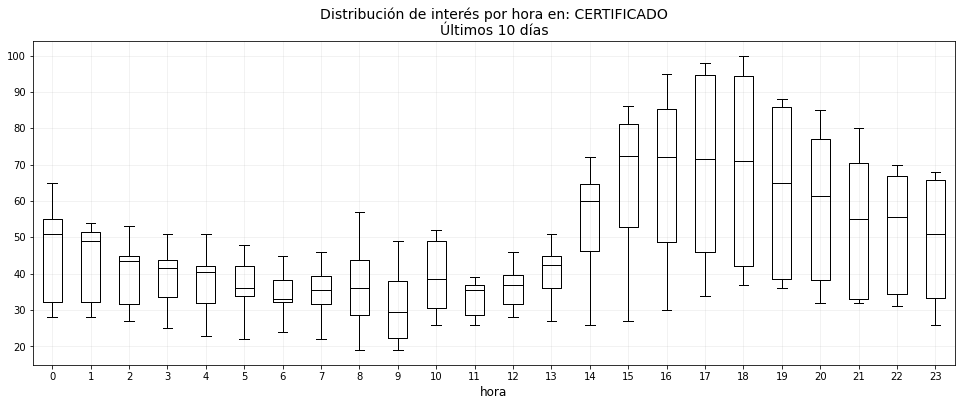

In [10]:
ax = hourly.boxplot(by='hour', column='certificado', figsize=(16,6), vert=True, color='black')

#Anotaciones y estilo
ax.set_title(label='Distribución de interés por hora en: CERTIFICADO\nÚltimos 10 días', fontsize=14)
ax.set_xlabel('hora', fontsize=12)
ax.grid(alpha=0.2)

plt.suptitle('')
plt.show()

### Interés por región

Regresa las regiones en las cuales la palabra clave fue más buscada

In [12]:
region = pytrends.interest_by_region(resolution='COUNTRY',
                           inc_low_vol=False,
                           inc_geo_code=True)

region.sort_values(by='certificado').tail()

,geoCode,certificado
geoName,,
Hidalgo,MX-HID,81
Campeche,MX-CAM,83
Tlaxcala,MX-TLA,92
Guerrero,MX-GRO,100
Coahuila de Zaragoza,MX-COA,100


In [13]:
region.shape

(32, 2)

### Temas relacionados

Regresa un diccionario de dataframes, que contienen información de las `keywords` relacionadas con el criterio de búsqueda.

**Primer nivel**
<br>La llave es el criterio de búsqueda

In [14]:
related = pytrends.related_topics()
type(related), len(related)

(dict, 1)

In [9]:
related.keys()

dict_keys(['certificado'])

**Segundo nivel**
<br>Las llaves son los temas relacionados:
* Top
* En aumento

In [10]:
type(related['certificado']), len(related['certificado'])

(dict, 2)

In [11]:
related['certificado'].keys()

dict_keys(['rising', 'top'])

**Inspenccionando** los temas `rising`

In [15]:
related['certificado']['rising']

,value,formattedValue,link,topic_mid,topic_title,topic_type
0,2353750,Breakout,/trends/explore?q=/g/11j2cc_qll&date=today+5-y...,/g/11j2cc_qll,Coronavirus disease 2019,Disease
1,1936900,Breakout,/trends/explore?q=/g/11j8_9sv06&date=today+5-y...,/g/11j8_9sv06,COVID-19 vaccine,Vaccine
2,39550,Breakout,/trends/explore?q=/m/07__7&date=today+5-y&geo=MX,/m/07__7,Vaccine,Topic
3,11950,Breakout,/trends/explore?q=/g/11n04t1m_2&date=today+5-y...,/g/11n04t1m_2,Ad5-nCoV,Vaccine
4,200,+200%,/trends/explore?q=/m/06r5rg&date=today+5-y&geo=MX,/m/06r5rg,Voucher,Topic
5,160,+160%,/trends/explore?q=/m/0kt51&date=today+5-y&geo=MX,/m/0kt51,Health,Topic
6,150,+150%,/trends/explore?q=/m/03rd6r&date=today+5-y&geo=MX,/m/03rd6r,Debtor,Topic
7,130,+130%,/trends/explore?q=/m/03jkw&date=today+5-y&geo=MX,/m/03jkw,HTTPS,Internet protocol
8,90,+90%,/trends/explore?q=/m/01bgz0&date=today+5-y&geo=MX,/m/01bgz0,Ballot,Topic


**Inspeccionando** los temas `top`

In [19]:
related['certificado']['top']

,value,formattedValue,hasData,link,topic_mid,topic_title,topic_type
0,100,100,True,/trends/explore?q=/g/1q6jhj1bs&date=2022-11-04...,/g/1q6jhj1bs,Certificado,Tema
1,17,17,True,/trends/explore?q=/m/07__7&date=2022-11-04T16+...,/m/07__7,Vacuna,Tema
2,13,13,True,/trends/explore?q=/g/11j2cc_qll&date=2022-11-0...,/g/11j2cc_qll,COVID-19,Enfermedad
3,11,11,True,/trends/explore?q=/m/04ztj&date=2022-11-04T16+...,/m/04ztj,Matrimonio,Tema
4,8,8,True,/trends/explore?q=/g/11j8_9sv06&date=2022-11-0...,/g/11j8_9sv06,Vacuna contra COVID-19,Vacuna
5,7,7,True,/trends/explore?q=/m/079h0&date=2022-11-04T16+...,/m/079h0,Educación secundaria,Campo de estudio
6,6,6,True,/trends/explore?q=/m/0fl33_&date=2022-11-04T16...,/m/0fl33_,certificado matrimonial,Tema
7,5,5,True,/trends/explore?q=/m/0kt51&date=2022-11-04T16+...,/m/0kt51,Salud,Tema
8,5,5,True,/trends/explore?q=/m/02rq2k1&date=2022-11-04T1...,/m/02rq2k1,Educación primaria,Categoría escolar
9,5,5,True,/trends/explore?q=/m/0bwwt8&date=2022-11-04T16...,/m/0bwwt8,Constancia,Documento


### Consultas relacionadas

Regresa la misma estrucctura que `related_topics`

**Primer nivel**
<br>La llave es el criterio de búsqueda

In [15]:
queries = pytrends.related_topics()
type(queries), len(queries)

(dict, 1)

In [16]:
queries.keys()

dict_keys(['certificado'])

**Segundo nivel**
<br>Las llaves son los temas relacionados:
* Top
* En aumento

In [17]:
queries['certificado'].keys()

dict_keys(['rising', 'top'])

**Inspenccionando** los temas `rising`

In [18]:
queries['certificado']['rising']

,value,formattedValue,link,topic_mid,topic_title,topic_type
0,2353750,Breakout,/trends/explore?q=/g/11j2cc_qll&date=today+5-y...,/g/11j2cc_qll,Coronavirus disease 2019,Disease
1,1936900,Breakout,/trends/explore?q=/g/11j8_9sv06&date=today+5-y...,/g/11j8_9sv06,COVID-19 vaccine,Vaccine
2,39550,Breakout,/trends/explore?q=/m/07__7&date=today+5-y&geo=MX,/m/07__7,Vaccine,Topic
3,11950,Breakout,/trends/explore?q=/g/11n04t1m_2&date=today+5-y...,/g/11n04t1m_2,Ad5-nCoV,Vaccine
4,200,+200%,/trends/explore?q=/m/06r5rg&date=today+5-y&geo=MX,/m/06r5rg,Voucher,Topic
5,160,+160%,/trends/explore?q=/m/0kt51&date=today+5-y&geo=MX,/m/0kt51,Health,Topic
6,150,+150%,/trends/explore?q=/m/03rd6r&date=today+5-y&geo=MX,/m/03rd6r,Debtor,Topic
7,130,+130%,/trends/explore?q=/m/03jkw&date=today+5-y&geo=MX,/m/03jkw,HTTPS,Internet protocol
8,90,+90%,/trends/explore?q=/m/01bgz0&date=today+5-y&geo=MX,/m/01bgz0,Ballot,Topic


**Inspeccionando** los temas `top`

In [19]:
queries['certificado']['top']

,value,formattedValue,hasData,link,topic_mid,topic_title,topic_type
0,100,100,True,/trends/explore?q=/g/1q6jhj1bs&date=today+5-y&...,/g/1q6jhj1bs,Certificate,Degree
1,44,44,True,/trends/explore?q=/m/07__7&date=today+5-y&geo=MX,/m/07__7,Vaccine,Topic
2,24,24,True,/trends/explore?q=/g/11j2cc_qll&date=today+5-y...,/g/11j2cc_qll,Coronavirus disease 2019,Disease
3,19,19,True,/trends/explore?q=/g/11j8_9sv06&date=today+5-y...,/g/11j8_9sv06,COVID-19 vaccine,Vaccine
4,8,8,True,/trends/explore?q=/m/079h0&date=today+5-y&geo=MX,/m/079h0,Secondary education,School category
5,3,3,True,/trends/explore?q=/m/05t4q&date=today+5-y&geo=MX,/m/05t4q,Physician,Occupation
6,3,3,True,/trends/explore?q=/m/0kt51&date=today+5-y&geo=MX,/m/0kt51,Health,Topic
7,2,2,True,/trends/explore?q=/g/1q6h_1zz4&date=today+5-y&...,/g/1q6h_1zz4,baccalaureate,Degree
8,2,2,True,/trends/explore?q=/m/02rq2k1&date=today+5-y&ge...,/m/02rq2k1,Primary education,School category
9,2,2,True,/trends/explore?q=/m/011b7yqg&date=today+5-y&g...,/m/011b7yqg,Certification,Topic


**Comparando** la información de salida entre `related_topics` y `related_queries`

In [25]:
print(related['certificado']['rising'].columns.to_list())
print(queries['certificado']['rising'].columns.to_list())

['value', 'formattedValue', 'link', 'topic_mid', 'topic_title', 'topic_type']
['value', 'formattedValue', 'link', 'topic_mid', 'topic_title', 'topic_type']


In [26]:
print(related['certificado']['top'].columns.to_list())
print(queries['certificado']['top'].columns.to_list())

['value', 'formattedValue', 'hasData', 'link', 'topic_mid', 'topic_title', 'topic_type']
['value', 'formattedValue', 'hasData', 'link', 'topic_mid', 'topic_title', 'topic_type']


En cuanto a campos se refiere, `related_topics` y `related_queries` entregan la misma información.

### Tendencias

Regresa información sobre los últimos temas en tendencia

[Documentación original](https://github.com/pat310/google-trends-api)

In [22]:
trends = pytrends.realtime_trending_searches(pn='MX', cat='h', count=100)
trends.head()

,title,entityNames
0,"Real Madrid CF, Rayo Vallecano, LaLiga, Karim ...","[Real Madrid CF, Rayo Vallecano, LaLiga, Karim..."
1,"Lunar eclipse, 2022","[Lunar eclipse, 2022]"
2,"Equatorial Guinea, France, Spain, Diplomat, Al...","[Equatorial Guinea, France, Spain, Diplomat, A..."
3,"Irene Bernasconi, Argentina, Google Doodle, Ec...","[Irene Bernasconi, Argentina, Google Doodle, E..."
4,"Andy Cruz, Boxing, Cuba, Cubans, Olympic champ...","[Andy Cruz, Boxing, Cuba, Cubans, Olympic cham..."


In [28]:
trends.shape

(61, 2)

**Inspeccionando** el tamaño de cada registro

In [29]:
trends.loc[0]['title']

'A.C. Monza, Bologna F.C. 1909, Serie A'

In [30]:
trends.loc[0]['entityNames']

['A.C. Monza', 'Bologna F.C. 1909', 'Serie A']

# Siguientes pasos

1) Identificar cuáles son las categorías que acepta el método de tendencia
2) Cuáles son los criterios de búsquda más comunes de acuerdo con la información del INAI